# Mixture Density Network
I learn MDN thanks to this post from @hardmaru

Source: http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/
I recomand to read his post first.

I took his code and adapted it so it can generate an output that contains multiples dimentions.

## Init environement and setup some helpers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math

In [2]:
def tf_assert_shape(tensors, requested_shape):
  if not type(tensors) is list:
    tensors = [tensors]
        
  for tensor in tensors:
    shape = tensor.get_shape().as_list()
    error_msg = 'Tensor {} has shape {} while shape {} was requested'.format(tensor.name, shape, requested_shape)
    assert shape == requested_shape, error_msg

## Generate some data

### Data dimentions

In [3]:
BATCH_SIZE = 2500
NSAMPLE = BATCH_SIZE
DIM = 3  # number of dimentions

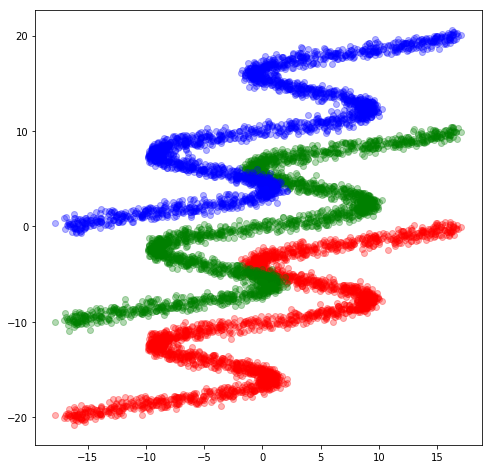

In [4]:
offset_data = np.float32(np.linspace(-10, 10, num=DIM))
y_data_one = np.float32(np.random.uniform(-10, 10, (NSAMPLE, 1)))
y_data = np.float32(np.random.uniform(-10, 10, (NSAMPLE, DIM)))
r_x = np.float32(np.random.normal(size=(NSAMPLE, 1)))
r_y = np.float32(np.random.normal(size=(NSAMPLE, 3)))
x_data= np.float32(np.sin(0.75*y_data_one)*7.0+y_data_one*1+r_x*0.4)

y_data[:,0] = y_data_one[:,0]
y_data[:,1] = y_data_one[:,0] 
y_data[:,2] = y_data_one[:,0] 
y_data = y_data + offset_data + r_y*0.4

plt.figure(figsize=(8, 8))
plt.plot(x_data , y_data[:,0],'ro', alpha=0.3)
plt.plot(x_data , y_data[:,1],'go', alpha=0.3)
plt.plot(x_data , y_data[:,2],'bo', alpha=0.3)
plt.show()

## Model

The model is a simple multilayer perceptrons with one hidden layer.

But instead of outputing one value for every output dimention, the neural network estimate the distribution of the output using a mixture au gaussian.

So the number of output neurons needed for one value is KMIX * 3, where KMIX is the number of guaussian needed to model the distribution and 3 because each gaussian is defined by 3 values: pi, mu and sigma.

The model is defined in two part.
* the multilayer perception
* the mixture density model


In [5]:
NHIDDEN = 24
STDEV = 0.5

KMIX = 10  # number of mixtures
NOUT = KMIX * DIM * 3  # pi, mu, sigma

FLOAT_TYPE = tf.float64

# Define input (x) and output (y)
# output can be higher dimension than x
x = tf.placeholder(dtype=FLOAT_TYPE, shape=[BATCH_SIZE, 1], name="x")
y = tf.placeholder(dtype=FLOAT_TYPE, shape=[BATCH_SIZE, DIM], name="y")

# Define coeficients
Wh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=FLOAT_TYPE))
bh = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=FLOAT_TYPE))
Wo = tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=FLOAT_TYPE))
bo = tf.Variable(tf.random_normal([1, NOUT], stddev=STDEV, dtype=FLOAT_TYPE))

# connect layers
hidden_layer = tf.nn.tanh(tf.matmul(x, Wh) + bh)
output = tf.matmul(hidden_layer,Wo) + bo

In [6]:
# get_mixture_coef take the output of a model and convert it to a mixture model
def get_mixture_coef(output, batch_size, data_size, mixture_size):
  tf_assert_shape(output, [batch_size, data_size * mixture_size * 3])  # 3 stand for pi, mu, stdev
  
  # split the output
  out_pi, out_sigma, out_mu = tf.split(output, 3, axis=1)
  tf_assert_shape([out_pi, out_sigma, out_mu], [batch_size, data_size * mixture_size])

  # reshape pi, sigma and mu
  new_shape = [batch_size, data_size, mixture_size]
  out_pi = tf.reshape(out_pi, new_shape)
  out_sigma = tf.reshape(out_sigma, new_shape)
  out_mu = tf.reshape(out_mu, new_shape)

  # pi is a distribution
  out_pi = tf.nn.softmax(out_pi, axis=2)
  # sigma value are on an exponetial scale
  out_sigma = tf.exp(out_sigma)

  return out_pi, out_sigma, out_mu

In [7]:
# Add the mixture model to the tf graph
out_pi, out_sigma, out_mu = get_mixture_coef(output, NSAMPLE, DIM, KMIX)

## Add the loss

In [8]:
oneDivSqrtTwoPI = 1 / math.sqrt(2*math.pi) # normalisation factor for gaussian, not needed.
def tf_normal(y, mu, sigma, batch_size, data_size):
  # check args
  tf_assert_shape(y, [batch_size, data_size])
  tf_assert_shape([mu, sigma], [batch_size, data_size, KMIX])
  
  y = tf.reshape(y, (batch_size, data_size, 1))  # add one dim to ease broadcast
  result = tf.subtract(y, mu)  # Broadcast should work now
  tf_assert_shape(result, [batch_size, data_size, KMIX])
  result = tf.multiply(result, tf.reciprocal(sigma))  # element wise
  result = -tf.square(result)/2  # element wise
  tf_assert_shape(result, [batch_size, data_size, KMIX])
  return tf.multiply(tf.exp(result), tf.reciprocal(sigma))*oneDivSqrtTwoPI

def get_lossfunc(out_pi, out_sigma, out_mu, y, batch_size, data_size):
  # check args
  tf_assert_shape(y, [batch_size, data_size])
  tf_assert_shape([out_pi, out_sigma, out_mu], [batch_size, data_size, KMIX])
  
  normal = tf_normal(y, out_mu, out_sigma, batch_size, data_size)
  tf_assert_shape(normal, [batch_size, data_size, KMIX])
  result = tf.multiply(normal, out_pi)  # element wise
  tf_assert_shape(result, [batch_size, data_size, KMIX])
  result = tf.reduce_sum(result, axis=2)
  tf_assert_shape(result, [batch_size, data_size])
  result = -tf.log(result)
  result = tf.reduce_mean(result)
  tf_assert_shape(result, [])
  return result

lossfunc = get_lossfunc(out_pi, out_sigma, out_mu, y, NSAMPLE, DIM)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(lossfunc)

## Trainning

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

NEPOCH = 15000
loss = np.zeros(NEPOCH) # store the training progress here.
for i in range(NEPOCH):
  loss[i], _ = sess.run((lossfunc, train_op), feed_dict={x: x_data, y: y_data})
  if i%500 == 0:
    print ('step:',i,'loss:',loss[i])

Instructions for updating:
Use `tf.global_variables_initializer` instead.
step: 0 loss: 6.0385829698
step: 500 loss: 2.48846643215
step: 1000 loss: 2.26182623591
step: 1500 loss: 2.04942838342
step: 2000 loss: 1.9577120701
step: 2500 loss: 1.86588776871
step: 3000 loss: 1.79685007353
step: 3500 loss: 1.74758087985
step: 4000 loss: 1.70823132754
step: 4500 loss: 1.67751283146
step: 5000 loss: 1.62117885899
step: 5500 loss: 1.60533843889
step: 6000 loss: 1.59184767476
step: 6500 loss: 1.56003656213
step: 7000 loss: 1.47955199678
step: 7500 loss: 1.46841923363
step: 8000 loss: 1.46521402983
step: 8500 loss: 1.46228720661
step: 9000 loss: 1.46058042653
step: 9500 loss: 1.45742299956
step: 10000 loss: 1.45366671036
step: 10500 loss: 1.4512961553
step: 11000 loss: 1.44989517229
step: 11500 loss: 1.45052651344
step: 12000 loss: 1.44915374995
step: 12500 loss: 1.44902360677
step: 13000 loss: 1.44911565002
step: 13500 loss: 1.44869219792
step: 14000 loss: 1.44569388497
step: 14500 loss: 1.44598

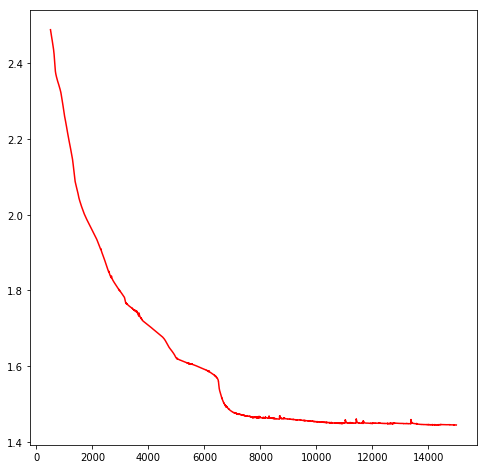

In [10]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(500, NEPOCH,1), loss[500:], 'r-')
plt.show()

## Sample the model

In [11]:
# Helper fonction to pick a gaussian according to the distribution
def generate_ensemble(out_pi, out_mu, out_sigma):
  result = np.zeros([NSAMPLE, DIM]) # initially random [0, 1]
  rn = np.random.randn(NSAMPLE, DIM) # normal random matrix (0.0, 1.0)
  for dim in range(DIM):  
    for i in range(NSAMPLE):
      idx = np.random.choice(KMIX, p=out_pi[i,dim])  
      mu = out_mu[i, dim, idx]
      std = out_sigma[i, dim, idx]
      result[i, dim] = mu + rn[i, dim]*std
  return result

In [12]:
# generate a new set of inputs
x_test = np.float32(np.arange(-12.5,12.5,0.01))
x_test = x_test[:NSAMPLE]
x_test = x_test.reshape(NSAMPLE, 1) # needs to be a matrix, not a vector

# ask the model to generate 
out_pi_test, out_sigma_test, out_mu_test = sess.run([out_pi, out_sigma, out_mu], feed_dict={x: x_test})

# generate the output using the model
y_test = generate_ensemble(out_pi_test, out_mu_test, out_sigma_test)

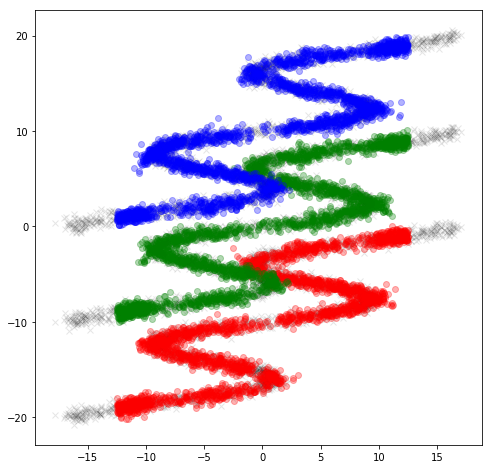

In [13]:
plt.figure(figsize=(8, 8))

plt.plot(x_data , y_data[:,0],'x', alpha=0.1, color='black')
plt.plot(x_data , y_data[:,1],'x', alpha=0.1, color='black')
plt.plot(x_data , y_data[:,2],'x', alpha=0.1, color='black')

plt.plot(x_test, y_test[:,0],'ro',alpha=0.3)
plt.plot(x_test, y_test[:,1],'go',alpha=0.3)
plt.plot(x_test, y_test[:,2],'bo',alpha=0.3)

plt.show()

## inspecting the model

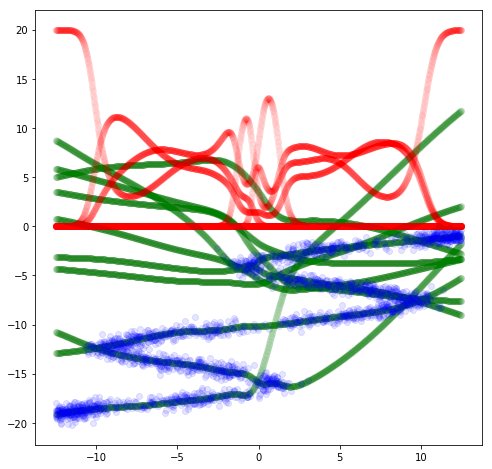

In [15]:
# Inspecting the first dimention mixture model
dim = 0
plt.figure(figsize=(8, 8))
plt.plot(x_test, out_mu_test[:,dim,:],'go', alpha=0.03)
plt.plot(x_test , y_test[:,dim],'bo',alpha=0.1)
plt.plot(x_test, out_pi_test[:,dim,:]*20,'ro', alpha=0.03)
plt.show()

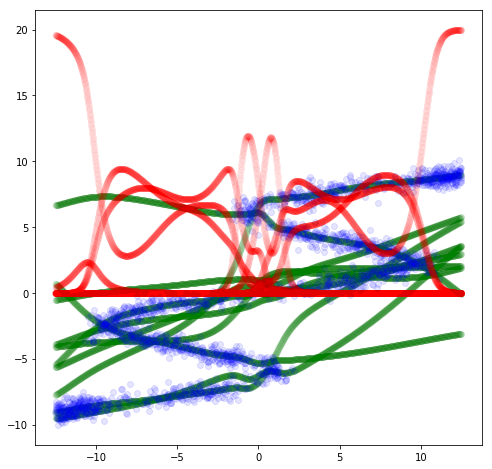

In [16]:
# Inspecting the scond dimention mixture model
dim = 1
plt.figure(figsize=(8, 8))
plt.plot(x_test, out_mu_test[:,dim,:],'go', alpha=0.03)
plt.plot(x_test , y_test[:,dim],'bo',alpha=0.1)
plt.plot(x_test, out_pi_test[:,dim,:]*20,'ro', alpha=0.03)
plt.show()

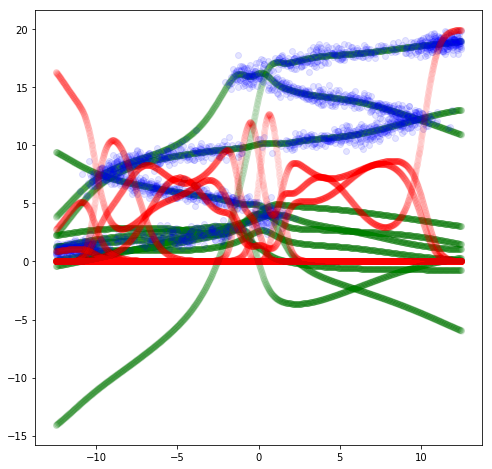

In [17]:
# Inspecting the first dimention mixture model
dim = 2
plt.figure(figsize=(8, 8))
plt.plot(x_test, out_mu_test[:,dim,:],'go', alpha=0.03)
plt.plot(x_test , y_test[:,dim],'bo',alpha=0.1)
plt.plot(x_test, out_pi_test[:,dim,:]*20,'ro', alpha=0.03)
plt.show()